### Check if configuration has been run already and change directory to repository root:

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [2]:
import datajoint as dj
import os
import getpass
import pandas as pd
import subprocess
import json

from u19_pipeline import recording, ephys, imaging_rec

#import utility.dj_shortcuts as dj_short
#import utility.acquisition_pipeline_handler as aph
dj.__version__

Connecting alvaros@datajoint00.pni.princeton.edu:3306


'0.13.2'

### Declare AutoPipeline and Status tables if they don't exist

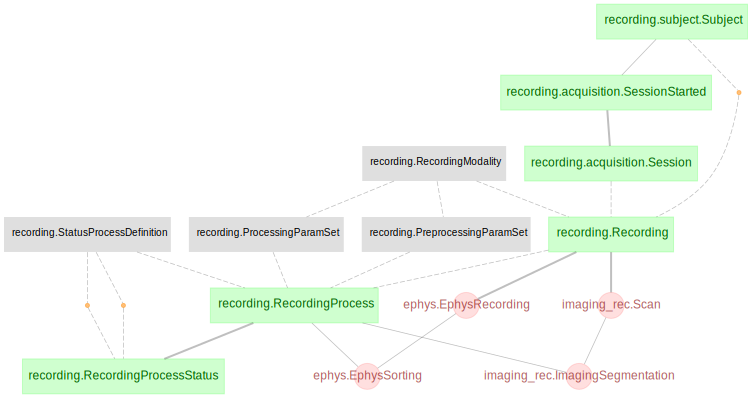

In [3]:
dj.ERD(recording) -1 + dj.ERD(ephys.EphysRecording) + dj.ERD(ephys.EphysSorting) + dj.ERD(imaging_rec.Scan) + dj.ERD(imaging_rec.ImagingSegmentation) 


In [ ]:
## Just for now, folders for ephys things in Globus
#FOR PNI endpoint
pni_ep_id = '6ce834d6-ff8a-11e6-bad1-22000b9a448b'
pni_ephys_root_data_dir   = '/jukebox/archive/brody/RATTER/PhysData/Raw/'
pni_ephys_sorted_data_dir = '/mnt/cup/labs/brody/RATTER/PhysData/Test_ephys_pipeline_NP_sorted/'

#For tiger endpoint
tiger_ep_dir = 'a9df83d2-42f0-11e6-80cf-22000b1701d1'
tiger_ephys_root_data_dir = '/tigress/alvaros/ephys_raw/'
tiger_ephys_sorted_data_dir = '/tigress/alvaros/ephys_sorted/'


### Delete and insert on the AcquisitionSessionsTestAutoPipeline and Status tables

In [ ]:
#acquisition.AcquisitionSessionsTestAutoPipeline.delete()
#acquisition.AcquisitionSessionsStatus.delete

### Get 5 "real" sessions to test and insert them to the TestAutoPipeline

In [ ]:
acq_sessions_df = pd.DataFrame(acquisition.AcquisitionSessions.fetch(limit=5, as_dict=True))
acq_sessions_df['status_pipeline'] = 0
acquisition.AcquisitionSessionsTestAutoPipeline.insert(acq_sessions_df, skip_duplicates=True)
acquisition.AcquisitionSessionsTestAutoPipeline()

### Check if logged to globus

In [4]:
s = subprocess.run(["globus", "whoami"], capture_output=True)
s.stdout.decode('UTF-8')

'alvaros@princeton.edu\n'

### Get all "active sessions"

In [5]:
sessions_active = acquisition.AcquisitionSessionsTestAutoPipeline & 'status_pipeline < 7 and status_pipeline >= 0'
df_sessions = pd.DataFrame(sessions_active.fetch(as_dict=True))

#Add a column to have a key dictionary as a new column
key_list = dj_short.get_primary_key_fields(acquisition.AcquisitionSessionsTestAutoPipeline)
df_sessions['query_key'] = df_sessions.loc[:, key_list].to_dict(orient='records')
df_sessions

,sessid,status_pipeline,session_rat,session_userid,session_rigid,acquisition_type,acquisition_raw_rel_path,acquisition_post_rel_path,task_copy_id_pre_path,task_copy_id_pos_path,slurm_id_sorting,query_key
0,590577,0,T173,zhihaol,202,ephys,Ann/misc,TestFolder2,None,None,None,{'sessid': 590577}


In [6]:
import time
for i in range(30):
    
    aph.pipeline_handler_main()
    time.sleep(3)
    

0    0
Name: status_pipeline, dtype: int64
['globus', 'transfer', '6ce834d6-ff8a-11e6-bad1-22000b9a448b:/jukebox/archive/brody/RATTER/PhysData/Raw/Ann/misc', 'a9df83d2-42f0-11e6-80cf-22000b1701d1:/tigress/alvaros/ephys_raw/Ann/misc', '--recursive', '--format', 'json']
0    1
Name: status_pipeline, dtype: int64
['globus', 'task', 'show', 'd6aaa788-36b6-11ec-9e53-3df4ed83d858', '--format', 'json']
0    1
Name: status_pipeline, dtype: int64
0    1
Name: status_pipeline, dtype: int64
0    1
Name: status_pipeline, dtype: int64
0    1
Name: status_pipeline, dtype: int64
0    1
Name: status_pipeline, dtype: int64
0    1
Name: status_pipeline, dtype: int64
0    1
Name: status_pipeline, dtype: int64
['globus', 'task', 'show', 'd6aaa788-36b6-11ec-9e53-3df4ed83d858', '--format', 'json']
0    2
Name: status_pipeline, dtype: int64
['ssh', 'alvaros@tigergpu.princeton.edu', 'sbatch', '/tigress/alvaros/slurm_files/slurm_sessid_590577.slurm']
aftercommand before comm
aftercommand after comm
Submitted b

0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name: status_pipeline, dtype: int64
0    6
Name